# Preparing Data

In [3]:
import numpy as np
import scanpy as sc

adata = sc.read_h5ad("/home/jhaberbe/Projects/Personal/using_parameters_instead/data/16APR2025.h5ad")
folder_to_group_mapping = adata.obs[["folder", "group"]].drop_duplicates().set_index("folder")["group"].to_dict()

adata.obs["log_lipid_droplet_area"] = np.log1p(adata.obs["lipid_droplet_area"])
adata.obs["log_plin2_area"] = np.log1p(adata.obs["plin2_area"])
adata.obs["log_oil_red_o_area"] = np.log1p(adata.obs["oil_red_o_area"])
adata.obs["lipid_droplet"] = adata.obs["log_lipid_droplet_area"].gt(0).astype(int)
adata.obs["near_amyloid"] = adata.obs["distance_to_nearest_amyloid"].lt(60).astype(int)

/home/jhaberbe/Projects/Personal/using_parameters_instead/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
adata.obs.query("cell_type == 'Microglia-PVM'").groupby(["near_amyloid"])["lipid_droplet"].value_counts().unstack()

lipid_droplet,0,1
near_amyloid,,
0,31879,8446
1,1390,682


# Loading Modules

In [5]:
import sys
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("..")
from src.using_parameters_instead import formula, model, summary, statistics, plotting

importlib.reload(formula)
importlib.reload(model)
importlib.reload(summary)
importlib.reload(statistics)
importlib.reload(plotting)

<module 'src.using_parameters_instead.plotting' from '/home/jhaberbe/Projects/Personal/using_parameters_instead/scratch/../src/using_parameters_instead/plotting.py'>

# Primary Training Routing

In [16]:
subset.obs["lipid_droplet"]

cell_id
aakfgpnd-1    1
aamgnmek-1    0
abafimph-1    0
abekbicb-1    0
abfbjefi-1    0
             ..
oigpfknl-1    1
oijepkbj-1    1
oijfflff-1    0
oiljjllc-1    0
oimbjmgc-1    1
Name: lipid_droplet, Length: 42923, dtype: int64

In [ ]:
import pickle

for cell_type in adata.obs["cell_type"].unique():
    subset = adata[adata.obs["cell_type"].eq(cell_type) & adata.obs["spatial_groups_2960"].eq("Grey")]

    subset.obs["transcript_counts_red"] = np.log(subset.layers["counts"].sum(axis=1) / subset.layers["counts"].sum(axis=1).mean())

    design_matrix_factory = formula.DesignMatrixFactory(
        "folder", 
        ["lipid_droplet", "near_amyloid"],
        intercept = False
    )

    differential_expression_testing = model.DifferentialExpressionTesting(
        model.NegativeBinomialModelFitter(),
        design_matrix_factory
    )

    results = differential_expression_testing.fit_model_over_features(
        adata=subset, 
        layer="counts",
        min_expression=0.05,
        reset=False,
        offset=subset.obs["transcript_counts_red"]
    )
    
    pickle.dump(results, open(f"/home/jhaberbe/Projects/Personal/using_parameters_instead/output/larger-radius/{cell_type.replace('/', '-')}.pickle", "wb"))

100%|██████████| 366/366 [00:13<00:00, 27.76it/s]



# Statistical Testing

# Group (lipid droplet)

In [ ]:
import scipy.stats

def global_effect_plot(results, output_location, design_matrix_factory=design_matrix_factory, covariate = "oil_red_o"):
    summarizer = summary.ModelResultSummarizer(design_matrix_factory)
    df = summarizer.summary_dataframe(results, covariate=covariate)
    df = df.drop(["specimen", "interaction_term"], axis=1)

    table = pd.DataFrame({
        feature: {
            "statistic": test_result.statistic,
            "pvalue": test_result.pvalue * 366,
            "logFC": df[feature].mean(),
            "std": df[feature].std(),
        }
        for feature, test_result in {feature: scipy.stats.ttest_1samp(df[feature], 0) for feature in df.columns}.items()
    }).T.eval("log10p = -log10(pvalue)").rename(columns=dict(log10p = "-log10p"))

    plotting.volcano_plot(table, .3, top_n_genes=40)

    plt.title(f"{cell_type}\n{covariate}\n(Global Effect)")
    plt.savefig(output_location)

for cell_type in adata.obs["cell_type"].unique():
    results = pickle.load(open(f"/home/jhaberbe/Projects/Personal/using_parameters_instead/output/larger-radius/{cell_type.replace('/', '-')}.pickle", "rb"))
    global_effect_plot(results, output_location=f"/home/jhaberbe/Projects/Personal/using_parameters_instead/output/larger_radius/figures/{cell_type}.svg")

AttributeError: Can only use .str accessor with string values!

/home/jhaberbe/Projects/using_parameters_instead/scratch/../src/using_parameters_instead/summary.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interaction_term"] = df["index"] \
/home/jhaberbe/Projects/using_parameters_instead/scratch/../src/using_parameters_instead/plotting.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["color"] = "grey"
/home/jhaberbe/Projects/using_parameters_instead/scratch/../src/using_parameters_instead/summary.py:45: SettingWithCopyWarning: 
A value is trying to b

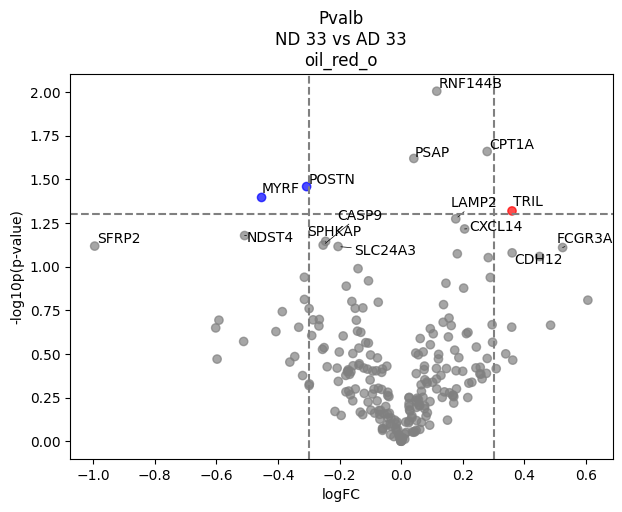

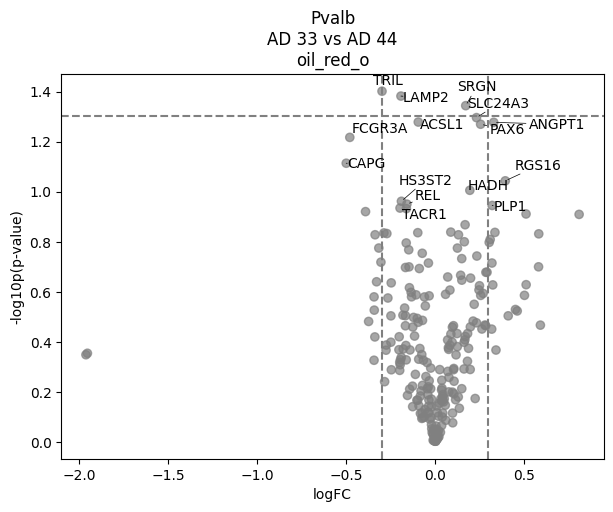

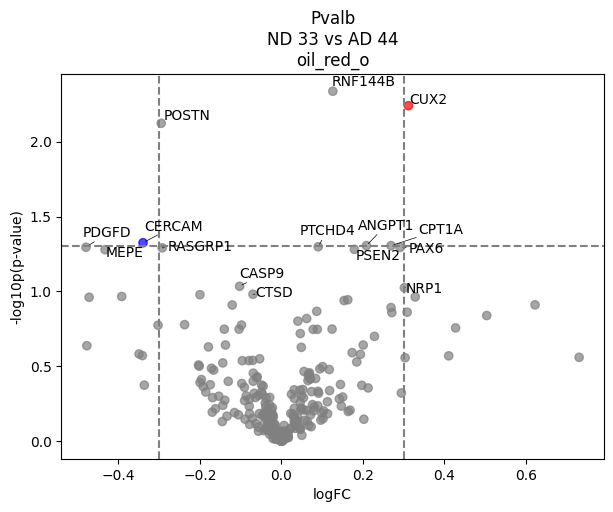

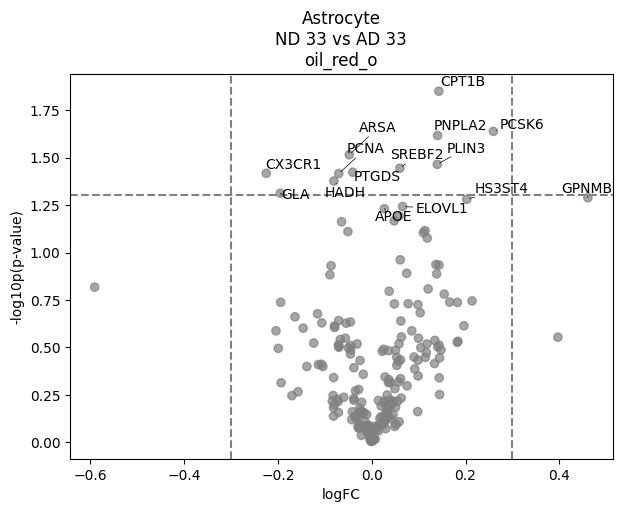

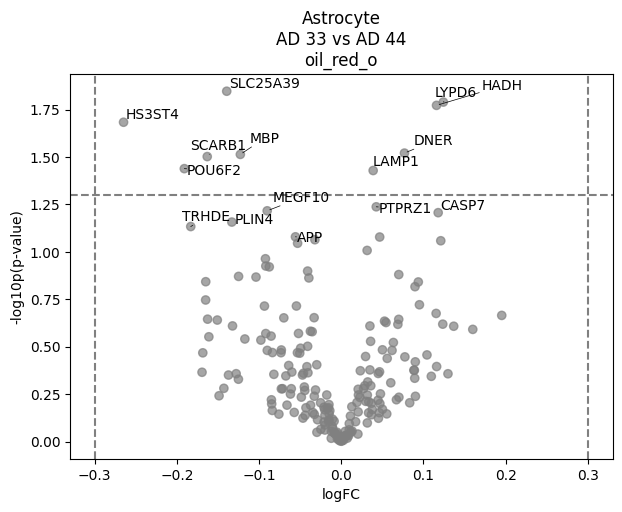

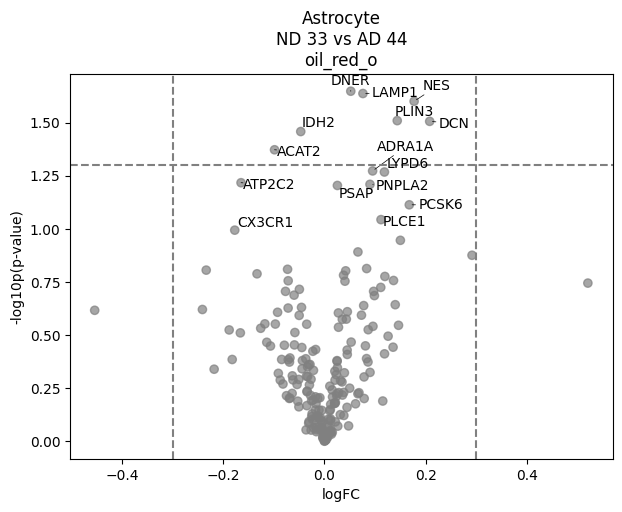

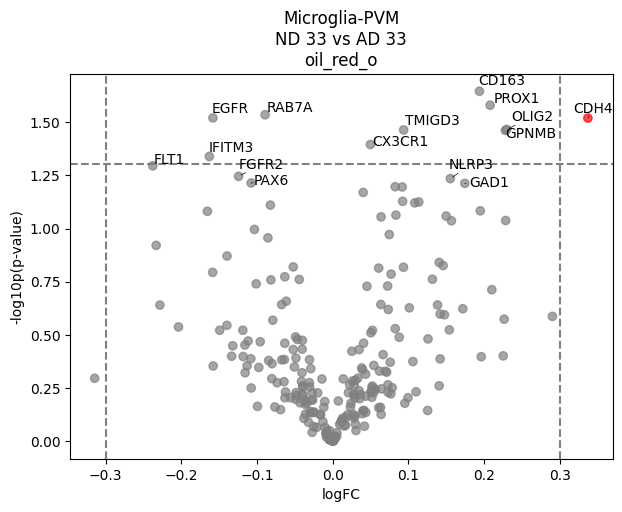

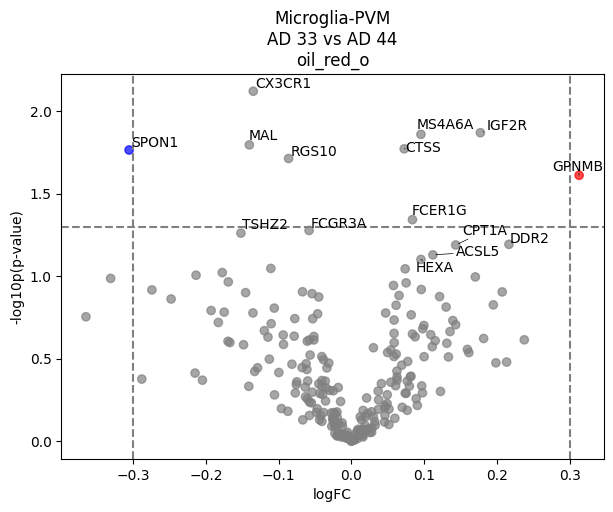

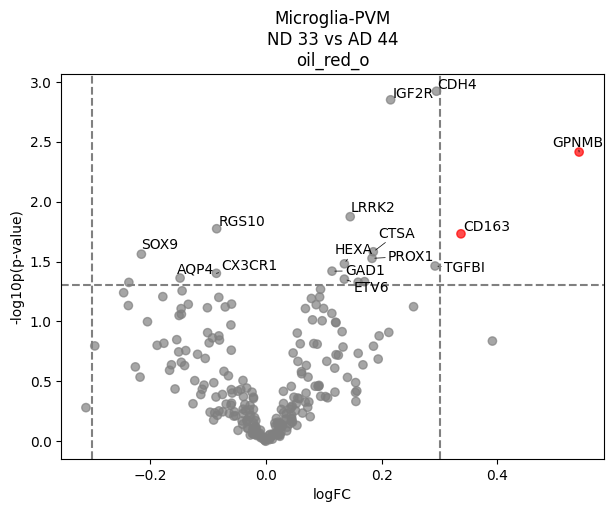

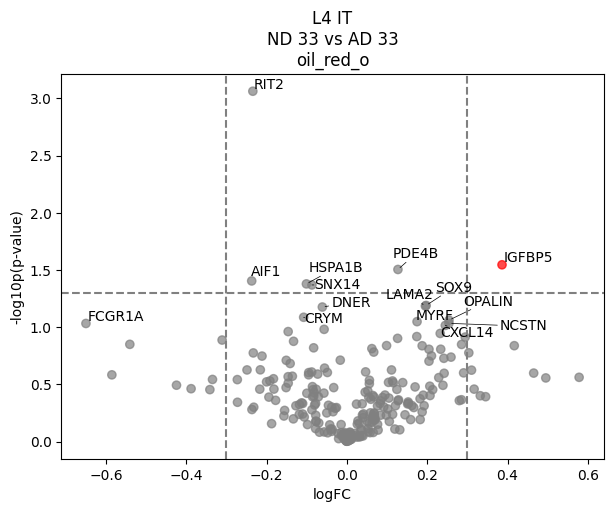

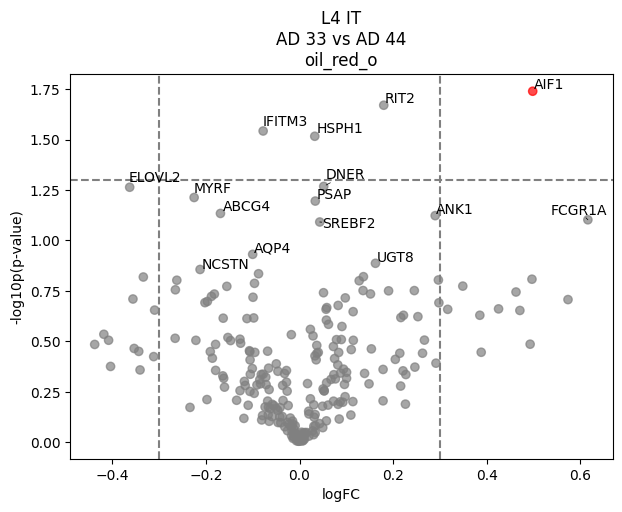

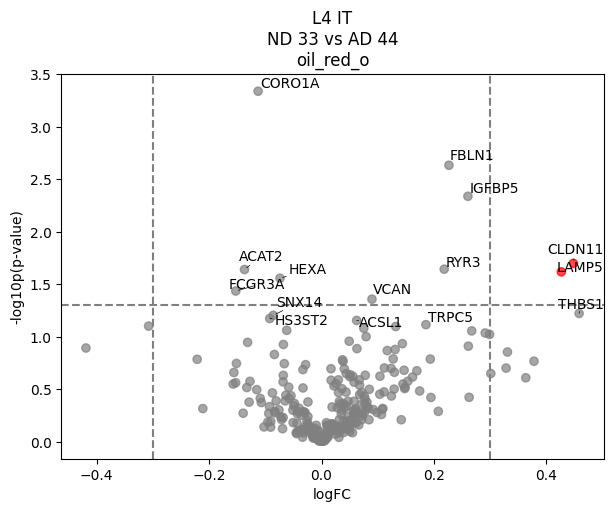

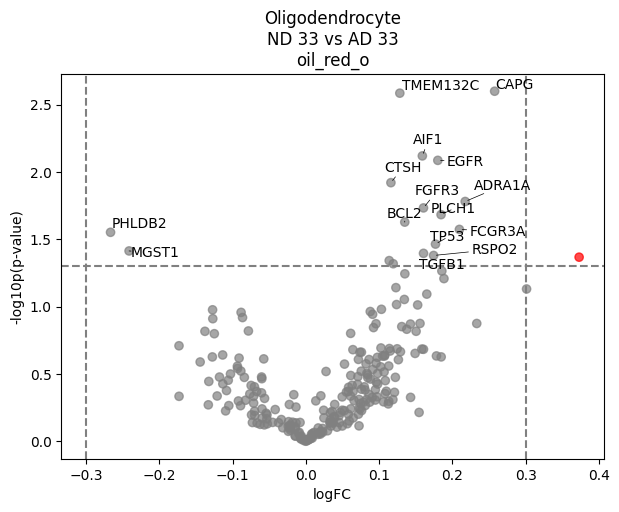

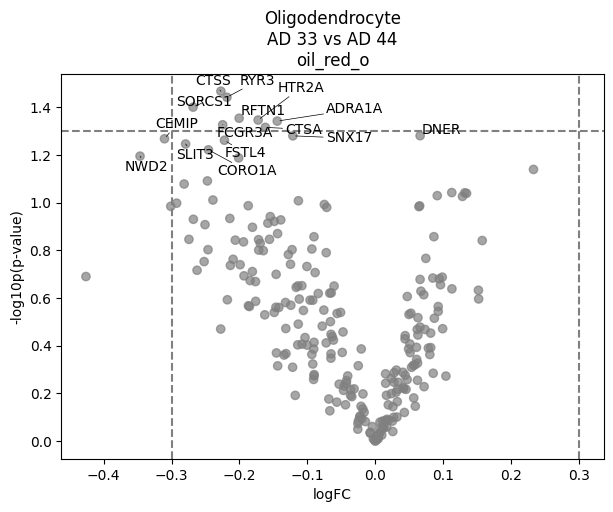

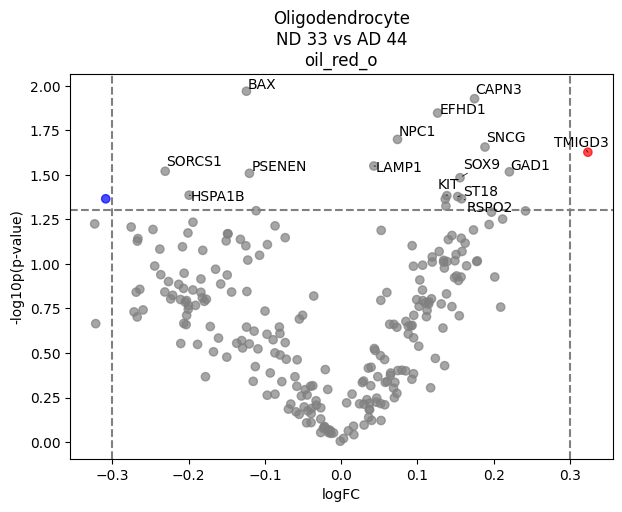

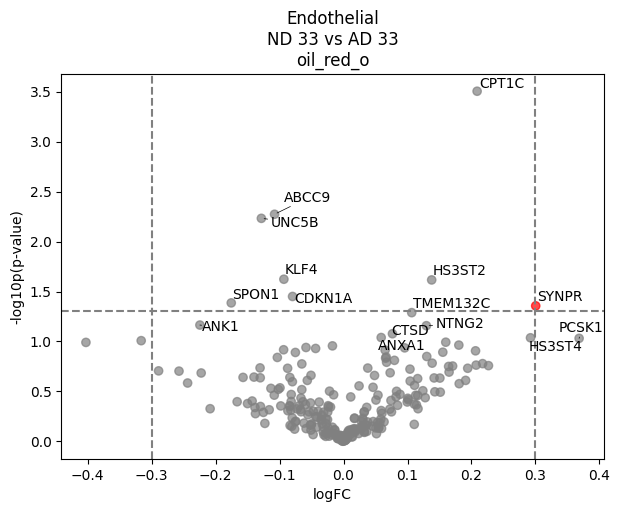

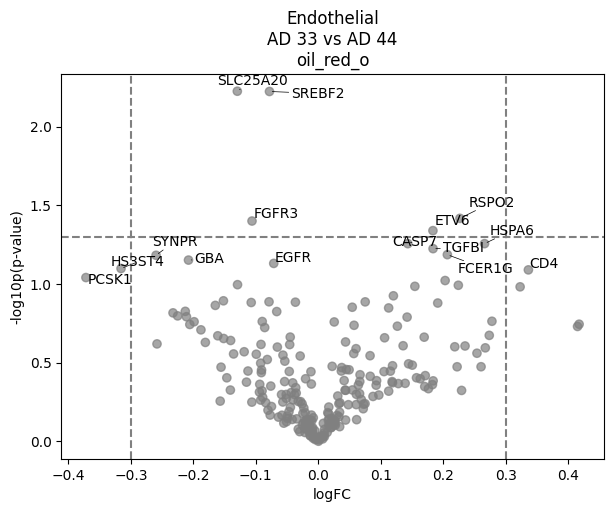

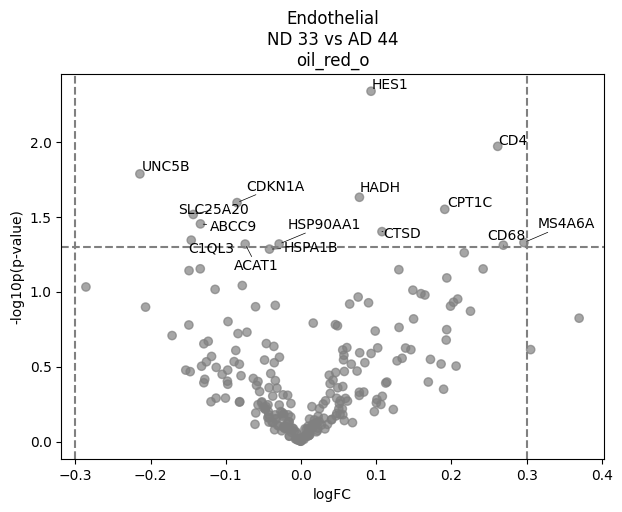

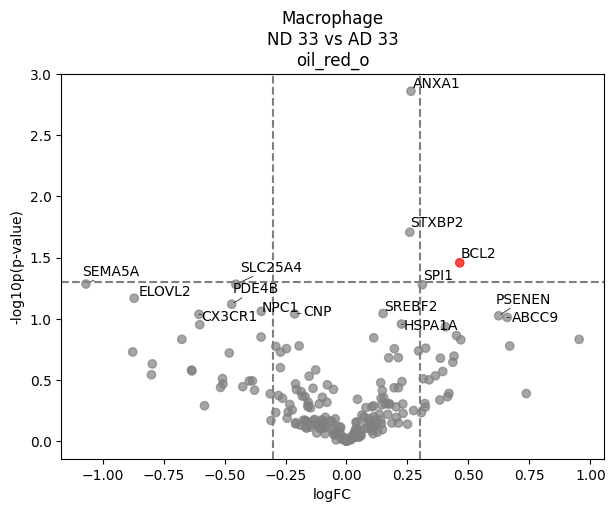

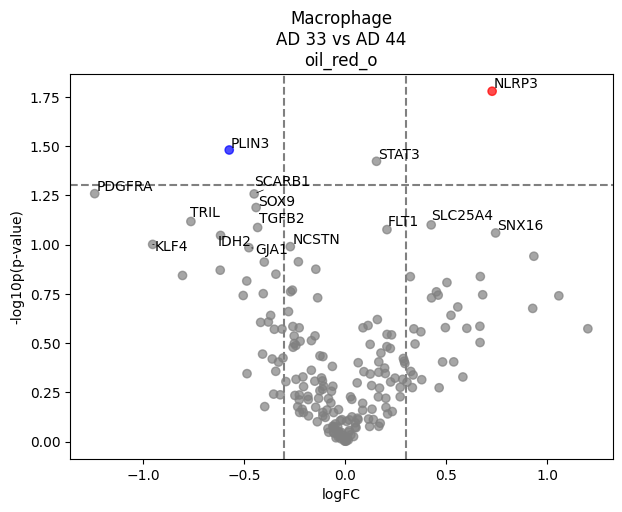

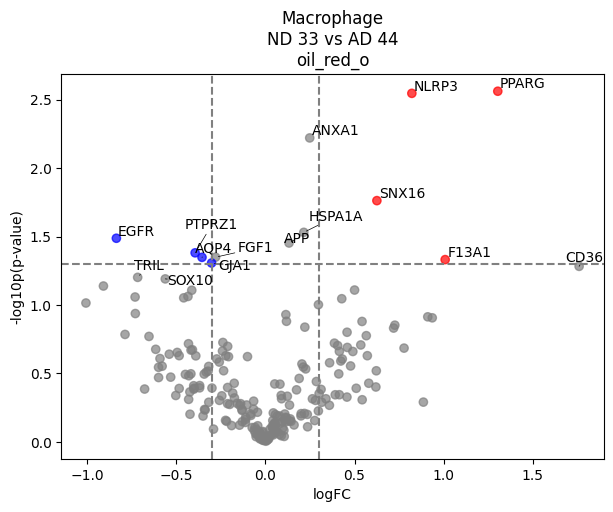

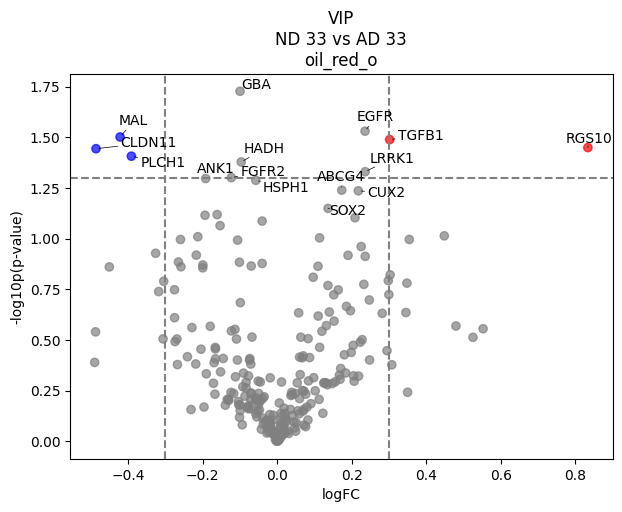

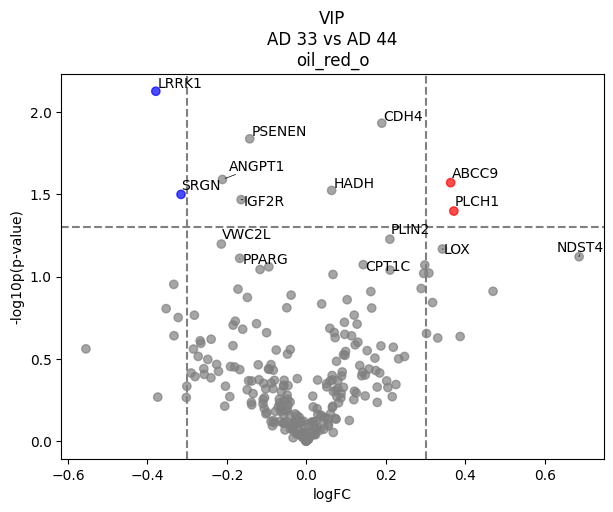

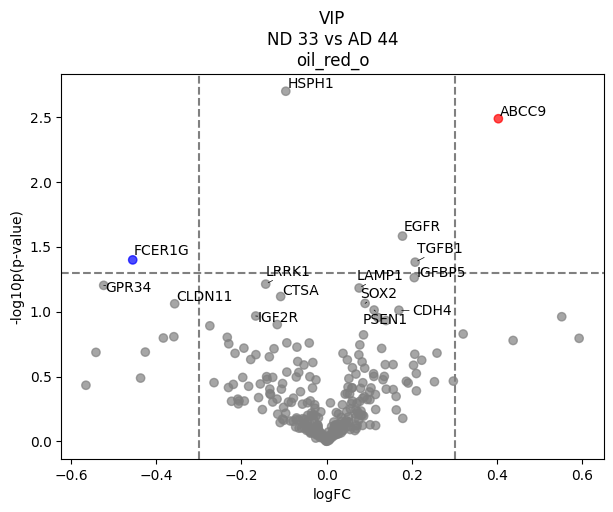

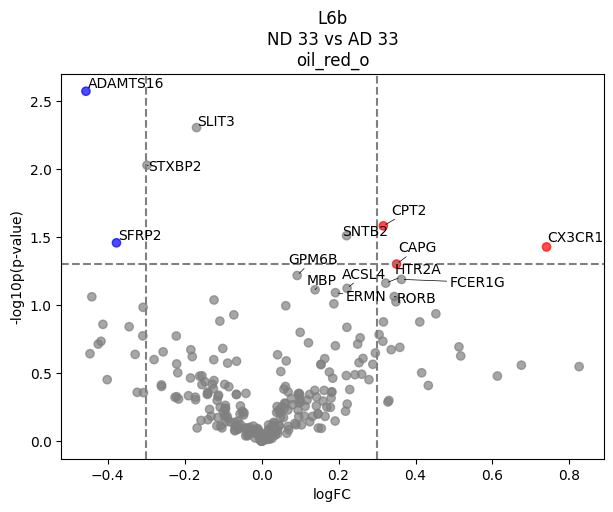

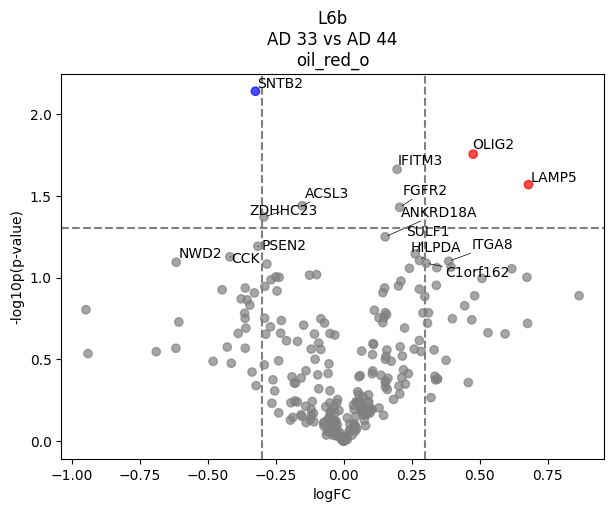

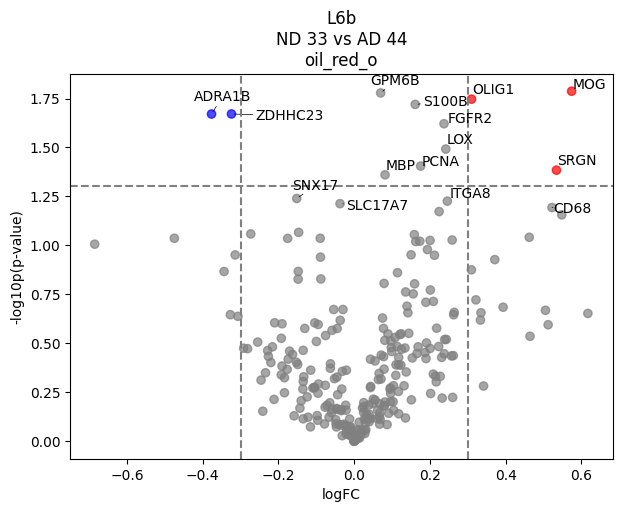

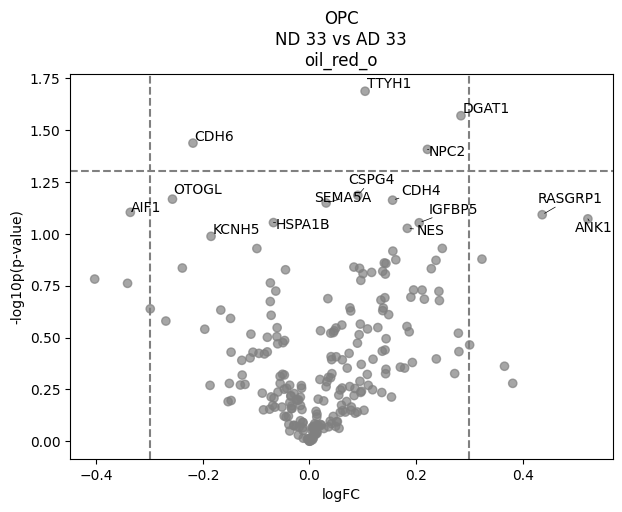

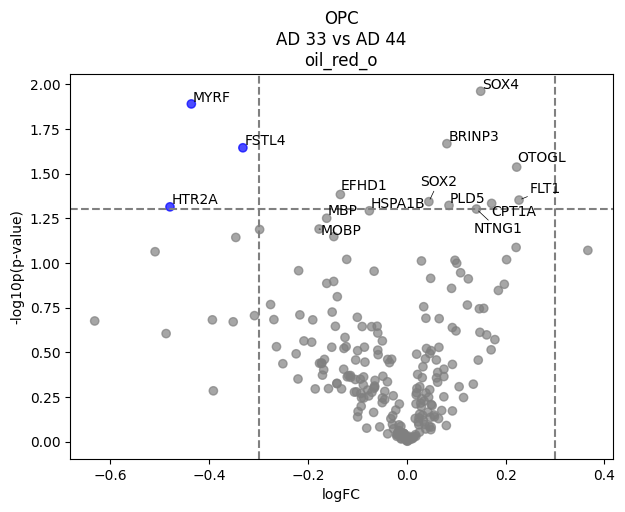

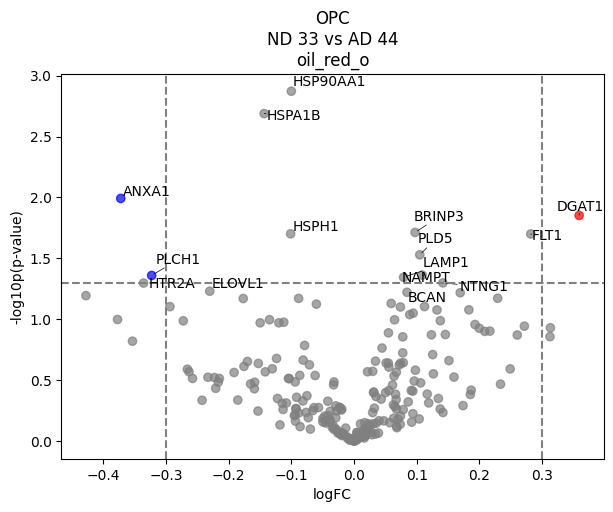

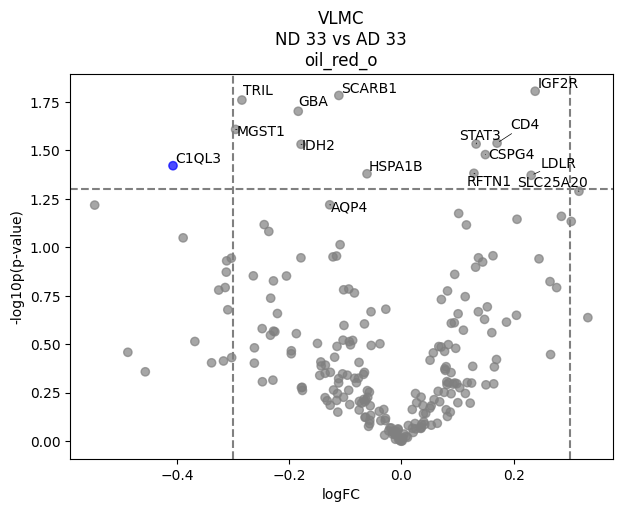

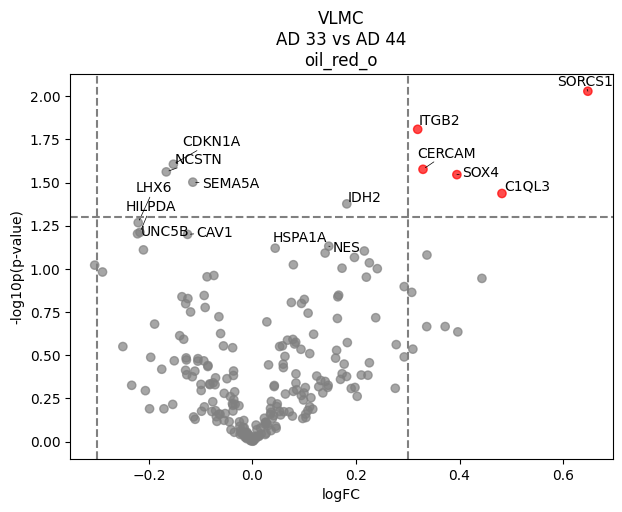

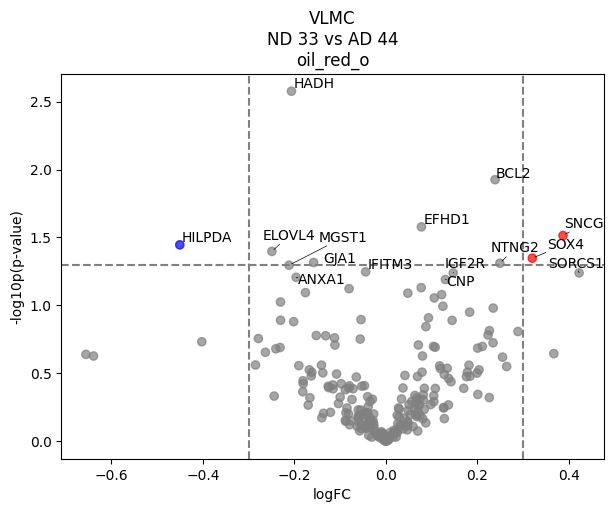

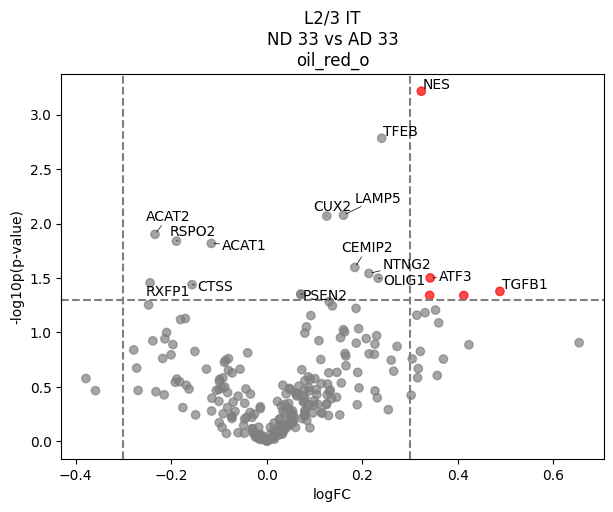

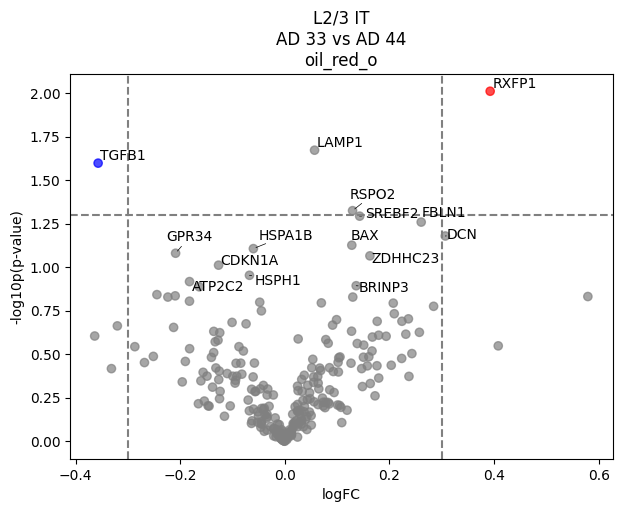

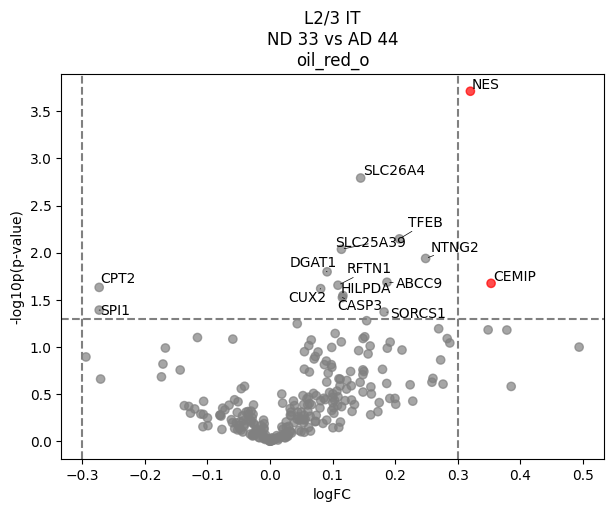

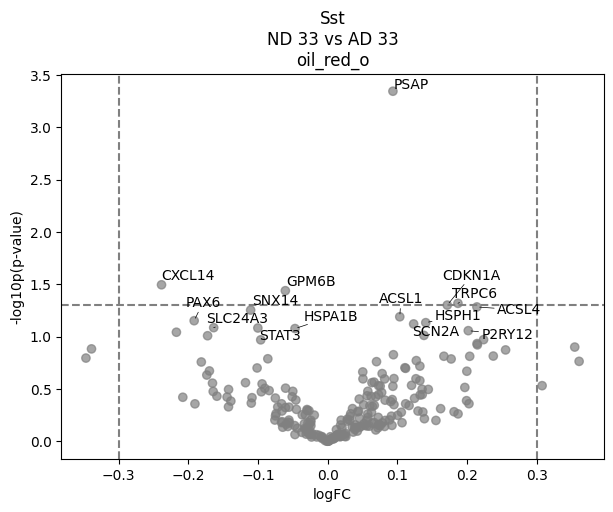

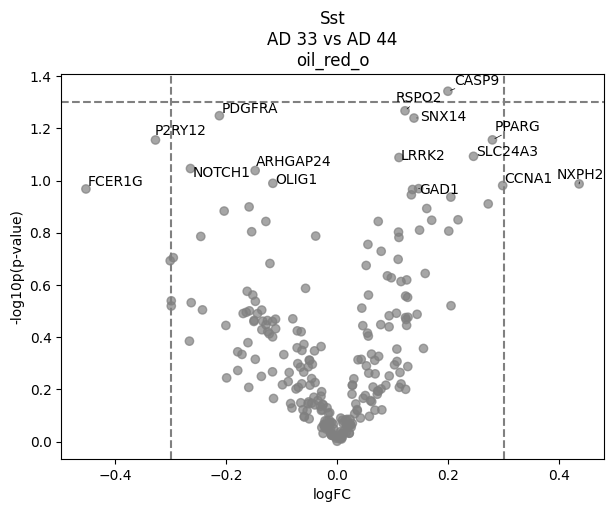

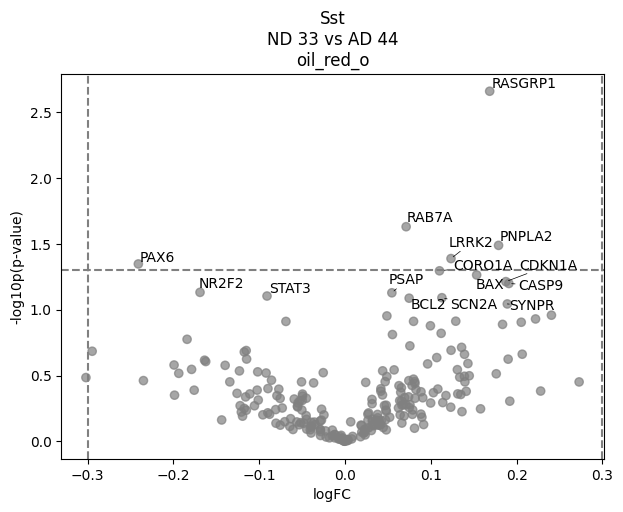

In [44]:
def group_level_differences(results, output_location, covariate="oil_red_o", design_matrix_factory=design_matrix_factory, g1="ND 33", g2="AD 33"):
    summarizer = summary.ModelResultSummarizer(design_matrix_factory)
    df = summarizer.summary_dataframe(results, covariate=covariate)
    df["group"] = df["specimen"].replace(folder_to_group_mapping)
    table = pd.DataFrame({
        feature: statistics.CoefficientStatistics(df).generate_stats_entry_dict(g1, g2, feature, equal_var=False)
        for feature in adata.var_names.intersection(df.columns)
    }).T
    ad_33 = table["logFC"]
    plotting.volcano_plot(table.query("abs(logFC) < 2"), .3)
    plt.title(f"{cell_type}\n{g1} vs {g2}\n{covariate}")
    plt.savefig(f"{output_location}/{cell_type.replace('/', '-')}_{g1}_{g2}.svg")

for cell_type in adata.obs["cell_type"].unique():
    results = pickle.load(open(f"/home/jhaberbe/Projects/using_parameters_instead/output/oro-only/{cell_type.replace('/', '-')}.pickle", "rb"))
    group_level_differences(results, output_location=f"/home/jhaberbe/Projects/using_parameters_instead/output/oro-only/figures/group-effect")
    group_level_differences(results, output_location=f"/home/jhaberbe/Projects/using_parameters_instead/output/oro-only/figures/group-effect", g1="AD 33", g2="AD 44")
    group_level_differences(results, output_location=f"/home/jhaberbe/Projects/using_parameters_instead/output/oro-only/figures/group-effect", g1="ND 33", g2="AD 44")

/home/jhaberbe/Projects/using_parameters_instead/scratch/../src/using_parameters_instead/summary.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interaction_term"] = df["index"] \


Text(0.5, 1.0, 'Microglia-PVM\nND 33 vs AD 44')

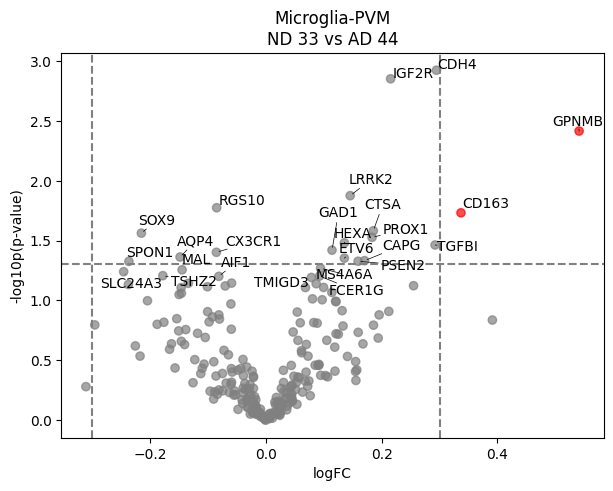

In [34]:
summarizer = summary.ModelResultSummarizer(design_matrix_factory)
df = summarizer.summary_dataframe(results, covariate="oil_red_o")
df["group"] = df["specimen"].replace(folder_to_group_mapping)
table = pd.DataFrame({
    feature: statistics.CoefficientStatistics(df).generate_stats_entry_dict("ND 33", "AD 44", feature, equal_var=False)
    for feature in adata.var_names.intersection(df.columns)
}).T
ad_44 = table["logFC"]
plotting.volcano_plot(table.query("abs(logFC) < 2"), .3, top_n_genes=25)
plt.title("Microglia-PVM\nND 33 vs AD 44")

/home/jhaberbe/Projects/using_parameters_instead/scratch/../src/using_parameters_instead/summary.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interaction_term"] = df["index"] \


Text(0.5, 1.0, 'Microglia-PVM\nAD 33 vs AD 44')

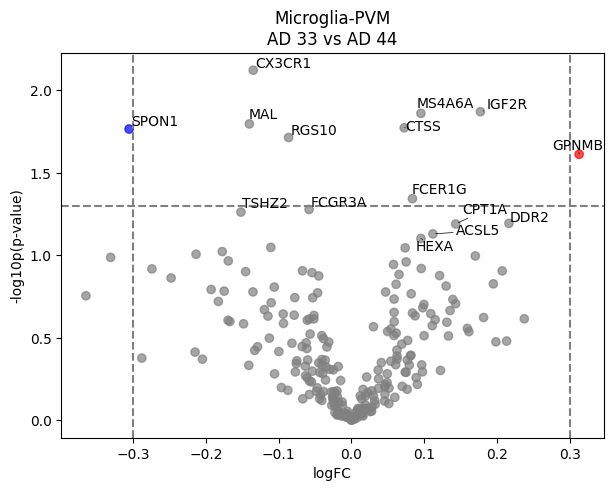

In [35]:
summarizer = summary.ModelResultSummarizer(design_matrix_factory)
df = summarizer.summary_dataframe(results, covariate="oil_red_o")
df["group"] = df["specimen"].replace(folder_to_group_mapping)
table = pd.DataFrame({
    feature: statistics.CoefficientStatistics(df).generate_stats_entry_dict("AD 33", "AD 44", feature, equal_var=False)
    for feature in adata.var_names.intersection(df.columns)
}).T
ad_44 = table["logFC"]
plotting.volcano_plot(table.query("abs(logFC) < 2"), .3)
plt.title("Microglia-PVM\nAD 33 vs AD 44")

<Axes: xlabel='group', ylabel='CDH4'>

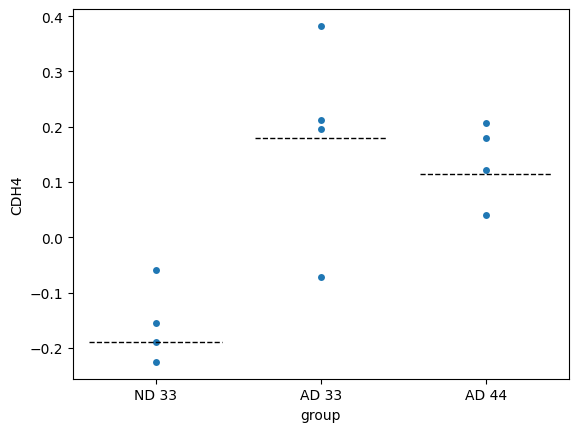

In [37]:
import seaborn as sns
gene = "CDH4"
sns.swarmplot(df, x="group", y=gene, order=["ND 33", "AD 33", "AD 44"])
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': 'dashed', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="group",
            y=gene,
            data=df.iloc[:-2],
            showfliers=False,
            showbox=False,
            showcaps=False)

<Axes: ylabel='GPNMB'>

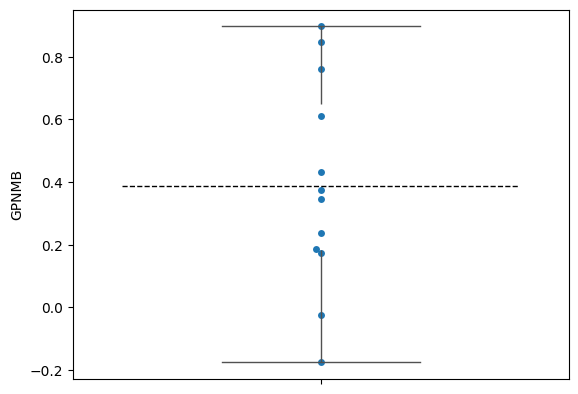

In [40]:
import seaborn as sns
gene = "GPNMB"

sns.swarmplot(df, y=gene)
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': 'dashed', 'lw': 1},
            medianprops={'visible': False},
            whiskerprops={'visible': True},
            zorder=10,
            y=gene,
            data=df,
            showfliers=False,
            showbox=False,
            showcaps=True)

# Group (near amyloid)

/oak/stanford/projects/kibr/Reorganizing/Packages/using_parameters_instead/src/using_parameters_instead/summary.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interaction_term"] = df["index"] \


Text(0.5, 1.0, 'Astrocyte\nND 33 vs AD 44')

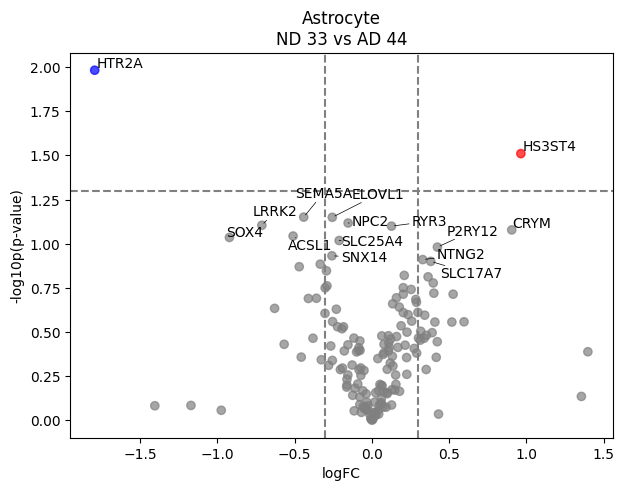

In [105]:
summarizer = summary.ModelResultSummarizer(design_matrix_factory)
df = summarizer.summary_dataframe(results, covariate="near_amyloid")
df["group"] = df["specimen"].replace(folder_to_group_mapping)
table = pd.DataFrame({
    feature: statistics.CoefficientStatistics(df).generate_stats_entry_dict("ND 33", "AD 33", feature, equal_var=False)
    for feature in adata.var_names.intersection(df.columns)
}).T.query("abs(logFC) < 2")
ad_44 = table["logFC"]
plotting.volcano_plot(table, .3)
plt.title("Astrocyte\nND 33 vs AD 44")

In [45]:
summarizer = summary.ModelResultSummarizer(design_matrix_factory)
df = summarizer.summary_dataframe(results, covariate="near_amyloid")
df["group"] = df["specimen"].replace(folder_to_group_mapping)
table = pd.DataFrame({
    feature: statistics.CoefficientStatistics(df).generate_stats_entry_dict("ND 33", "AD 44", feature, equal_var=False)
    for feature in adata.var_names.intersection(df.columns)
}).T.query("abs(logFC) < 2")
ad_44 = table["logFC"]
plotting.volcano_plot(table, .3)
plt.title("Microglia-PVM\nND 33 vs AD 44")

KeyError: 'AD 44'

<Axes: xlabel='group', ylabel='HILPDA'>

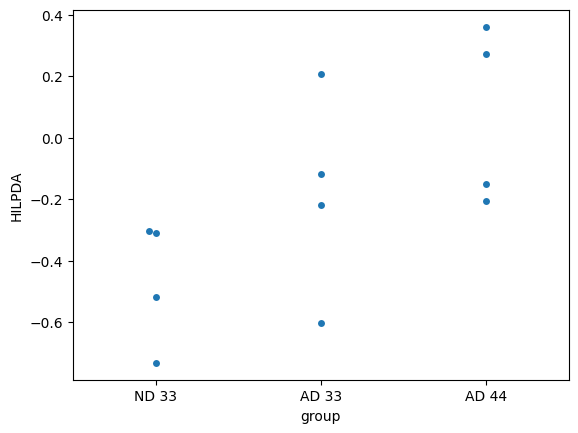

In [110]:
sns.swarmplot(df, x="group", y="HILPDA", order=["ND 33", "AD 33", "AD 44"])